# Change of the wavefunction along the ARP path
In this section, we study the change of the wavefunction along the ARP path.

In [1]:
# Import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from arc import *
# https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/installation.html
import scipy.constants as cts
from numpy.linalg import eig
from numba import jit
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import sys

In [2]:
# Some experimental parameters and constants
# Physical constants
a0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
h = cts.h  # Planck's constant in J*s
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second

## Extract the basis states and coefficients
We first need to write codes to help us extract the basis states and coefficients. We label the states in parabolic manifolds by the order of their energy levels, which is also the parabolic quantum number $n_1$.

In [3]:
# Extract the basis states and the wavefunction 
def getStateComposition(StarkMap, eField, n1):
    '''
    This function returns the state composition of the ARP states
    '''
    m = StarkMap.mat1 + StarkMap.mat2 * eField
    # we diagonalize the stark matrix
    ev, egvector = eigh(m)

    # find the state with n1

    wSortedIndices = np.argsort(ev)
    energy = ev[wSortedIndices[n1]] # n1 is also the order of the energy
    # the stateComposition is the eigenvector of the nth eigenvalue
    stateComposition = egvector[:,wSortedIndices[n1]]
    
    basisStates = StarkMap.basisStates  

    return energy, stateComposition, basisStates




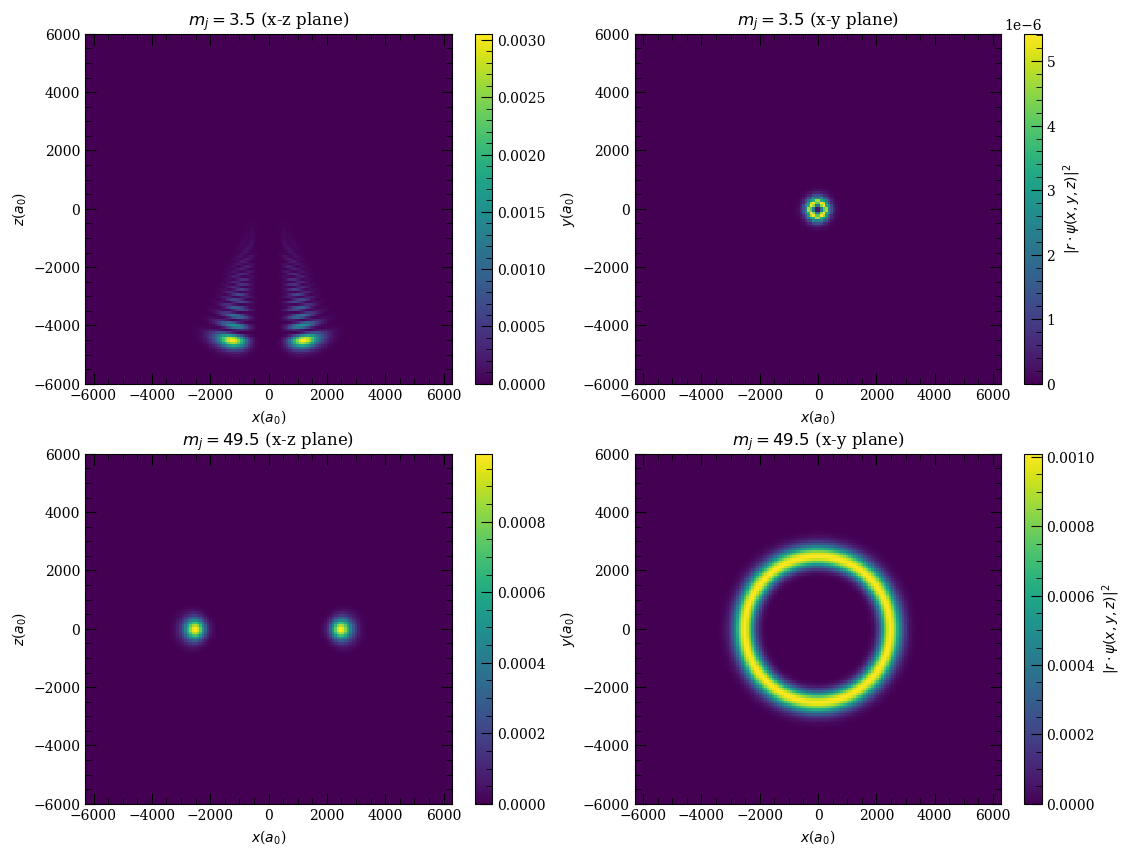

In [7]:
# Below is an example of plotting the wavefunction
atom = Rubidium()
eField = 250
n0 = 50
mj0s = [3.5,49.5]
# mj values we want to plot
l0 = n0-1
j0 = l0 + 0.5
minn = n0
maxn = n0 + 1
maxL = n0 - 1
q = 1

fig = plt.figure(figsize=(13, 5*len(mj0s)))
i = 1
unitLabel = r"$a_0$"
for mj0 in mj0s:
    
    stMap = StarkMap(atom)
    stMap.defineBasis(
        n0, l0, j0, mj0, minn, maxn, maxL, progressOutput=False, mlBasis=True
    )

    energy, stateComposition, basisStates = getStateComposition(stMap, eField, 0)
    StateWavefunction = Wavefunction(atom, basisStates, stateComposition)
    x, y, f = StateWavefunction.getRtimesPsiSquaredInPlane(plane='x-z')
    ax=fig.add_subplot(len(mj0s),2,i)
    
    cp = ax.pcolor(x, y, f, vmin=0, vmax=f.max(), cmap="viridis")
    ax.axis('equal')
    plt.xlabel(r"$x$(%s)"% unitLabel)
    ax.set_xlim([-6000, 6000])
    plt.ylabel(r"$z$(%s)"% unitLabel)
    ax.set_ylim([-6000, 6000])
    ax.set_title(r"$m_j = %s$"% mj0+" (x-z plane)")
    cb = fig.colorbar(cp)
    i += 1
    x, y, f = StateWavefunction.getRtimesPsiSquaredInPlane(plane='x-y')
    ax=fig.add_subplot(len(mj0s),2,i)
    cp = ax.pcolor(x, y, f, vmin=0, vmax=f.max(), cmap="viridis")
    i += 1
    ax.axis('equal')
    plt.xlabel(r"$x$(%s)"% unitLabel)
    ax.set_xlim([-6000, 6000])
    plt.ylabel(r"$y$(%s)"% unitLabel)
    ax.set_ylim([-6000, 6000])
    ax.set_title(r"$m_j = %s$"% mj0+" (x-y plane)")
    cb = fig.colorbar(cp)
    cb.set_label(
        r"$|r\cdot\psi(x,y,z)|^2$"
    ) 
    


In [11]:
# 3D plot
atom = Rubidium()
eField = 250
n0 = 50
mj0s = [3.5, 20.5, 30.5, 49.5]
l0 = n0-1
j0 = l0 + 0.5
minn = n0
maxn = n0 + 1
maxL = n0 - 1
q = 1

fs = []
for mj0 in mj0s:
    stMap = StarkMap(atom)
    stMap.defineBasis(
        n0, l0, j0, mj0, minn, maxn, maxL, progressOutput=False, mlBasis=True
    )

    energy, stateComposition, basisStates = getStateComposition(stMap, eField, 0)
    StateWavefunction = Wavefunction(atom, basisStates, stateComposition)

    # Decide parameters
    nMax = 1
    pointsPerAxis = 150
    for state in StateWavefunction.basisStates:
        nMax = max(nMax, state[0])
    axisLength = 2.0 * 2.0 * nMax * (nMax + 15.0)

    coord1 = np.linspace(-axisLength / 2.0, axisLength / 2.0, pointsPerAxis)
    coord2 = np.linspace(-axisLength / 2.0, axisLength / 2.0, pointsPerAxis)
    coord3 = np.linspace(-axisLength / 2.0, axisLength / 2.0, pointsPerAxis)
    meshCoord1, meshCoord2, meshCoord3 = np.meshgrid(coord1, coord2, coord3)

    coord =[meshCoord1, meshCoord2, meshCoord3]

    wfP, wfM = StateWavefunction.getRtimesPsi(*coord)

    f = np.power(np.abs(wfP), 2.0) + np.power(np.abs(wfM), 2.0)
    fs.append(f)

In [ ]:
import plotly.graph_objects as go
import numpy as np
i=0
'''
for mj0 in mj0s:
    f = fs[i]
    fig = go.Figure(data=go.Isosurface(
        x=meshCoord1.flatten(),
        y=meshCoord2.flatten(),
        z=meshCoord3.flatten(),
        value=f.flatten(),
        isomin=0.0002,
        isomax=0.001,
        surface_count = 5,
        caps=dict(x_show=False, y_show=False)
        ))
    fig.show()
    fig.write_html("wavefunction"+str(mj0)+".html")
    i+=1
'''

## Extract the basis states and coefficients with the rf coupling

In [4]:
# Load the data
fileName = 'data/parabolic_stark_diamond50.npz'
n0 = np.load(fileName)['n0']
mj0s = np.load(fileName)['mj0s']
eFieldList = np.load(fileName)['eFieldList']
dipoleMatrixElements = np.load(fileName)['dipoleMatrixElements']
transitionFrequencies = np.load(fileName)['transitionFrequencies']
energyShifts = np.load(fileName)['energyShifts']



In [5]:
# Calculate the Rabi frequency
E0 = 50 # electric field in V/m
rabiFrequencies = E0*dipoleMatrixElements/hbar*a0*e*(1e-9) # in GHz

In [6]:

mj0s = np.arange(3.5,50.5,1)
atom = Rubidium()
di = len(mj0s) # dimension of the Hamiltonian matrix
Er = 250 # The electric field at resonance in V/m

# resonance laser energy in GHz
laserEnergy = np.interp(Er, eFieldList, transitionFrequencies[0])

hamiltonian_matrix = np.zeros((di,di),dtype = complex)
energys = [[] for i in range(di)]
eigenStates = [[] for i in range(di)]

# Diagonal elements are energy shifts
minEfield = min(eFieldList)
initialStates = []
for m in range(len(eFieldList)):

    diagonals = [(energyShifts[n][m]-energyShifts[0][m]-laserEnergy*n) for n in range(di)]
    for i in range(di):
        hamiltonian_matrix[i,i] = diagonals[i]
        hamiltonian_matrix[0,0] = 0
    
        if i < di-1:
            hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0.5*rabiFrequencies[i][0]
            #hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0
    


    w, v = eig(hamiltonian_matrix)
    
    #----------------------Track the state ----------------------
    for i in range(di):
        if m==0:
            w_sorted_indices = np.argsort(w)
            initialState = v[:,w_sorted_indices[i]]
            initialStates.append(initialState)
            energys[i].append(w[w_sorted_indices[i]])
            eigenStates[i].append(v[:,w_sorted_indices[i]])
        else:
            maxOverlap = 0
            eigenvectorIndex = 0
            for j in range(di):
                overlap = np.abs(np.vdot(v[:,w_sorted_indices[j]],initialStates[i]))
                if overlap > maxOverlap:
                    maxOverlap = overlap
                    eigenvectorIndex = j
            energys[i].append(w[w_sorted_indices[eigenvectorIndex]])
            eigenStates[i].append(v[:,w_sorted_indices[eigenvectorIndex]])
            initialStates[i] = v[:,w_sorted_indices[eigenvectorIndex]]
    #--------------------------------------------------------------
    
    
    
energys = np.array(energys)

c:\Users\Chen\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


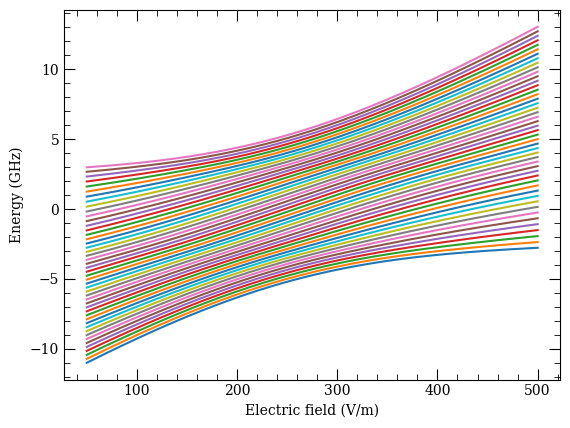

In [7]:
for i in range(di):
    plt.plot(eFieldList,energys[i], label = 'mj0 = '+str(mj0s[i]))
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy (GHz)')
#plt.legend()
plt.show()


In [8]:
# Convert the basis states to new basis
    
def convertBasis(eField, eigenVector):
    
    atom = Rubidium()
    n0 = 50
    l0 = n0-1
    j0 = l0 + 0.5
    minn = n0
    maxn = n0 + 1
    maxL = n0 - 1
    q = 1

    totalBasisStates = []
    totalStateComposition = []
    for mj0 in mj0s:
        i = np.where(mj0s == mj0) # index of mj0

        stMap = StarkMap(atom)
        stMap.defineBasis(
            n0, l0, j0, mj0, minn, maxn, maxL, progressOutput=False, mlBasis=True
        )

        energy, stateComposition, basisStates = getStateComposition(stMap, eField, 0)
        totalBasisStates += basisStates # get the total basis states
        newStateComposition = [(eigenVector[i]*stateComposition[m]) for m in range(len(stateComposition))]
        totalStateComposition += newStateComposition

    return totalBasisStates, totalStateComposition  

    
        


        



In [9]:
eField = 250
lenth = np.arange(len(eFieldList))
k = np.interp(eField, eFieldList, lenth) # index of the electric field in the list
eigenVector = eigenStates[0][int(k)]
BaseStates, StateComposition = convertBasis(eField, eigenVector)


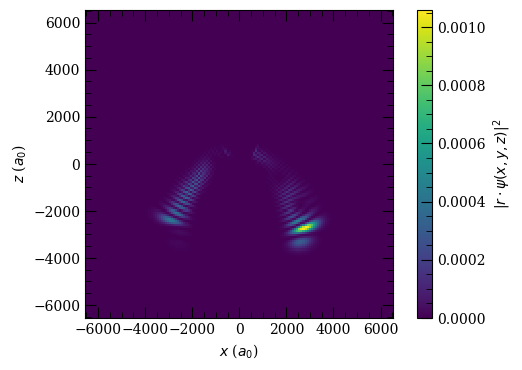

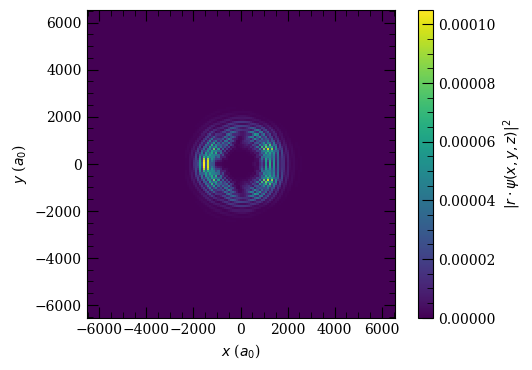

In [11]:
StateWavefunction = Wavefunction(atom, BaseStates, StateComposition)
StateWavefunction.plot2D(plane='x-z')
StateWavefunction.plot2D(plane='x-y')